In [53]:
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import colormaps
mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.size"] = 25
from simpsom import plots as splots
from simpsom.neighborhoods import Neighborhoods
import numpy as np
import xarray as xr
from sklearn.cluster import Birch
from jetstream_hugo.data import open_da, smooth
from jetstream_hugo.plots import *
from jetstream_hugo.definitions import get_region, Timer
from jetstream_hugo.jet_finding import flatten_by, cluster_generic, jets_from_mask, MultiVarExperiment, extract_features

import cartopy.crs as ccrs
from functools import partial
from skimage.filters import sato

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# SOM Neighbour difference plots

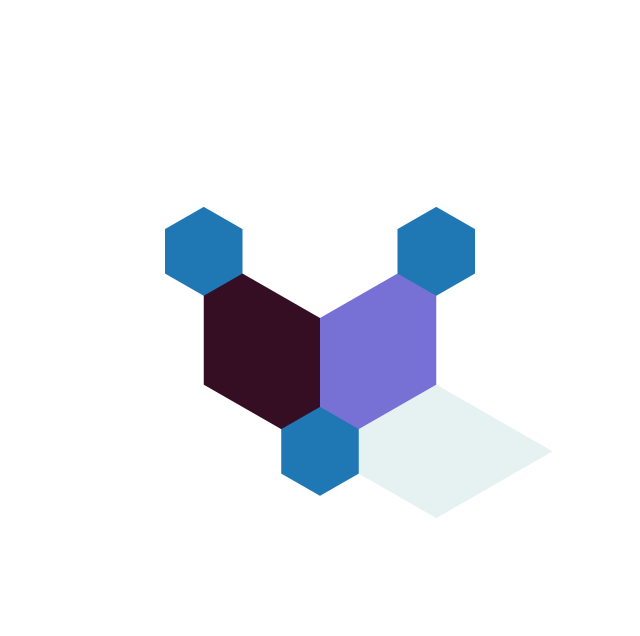

In [175]:
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, Polygon
from matplotlib.collections import PatchCollection
size = 3
polygon = RegularPolygon(
    (0, 0),
    numVertices=6,
    radius=size / np.sqrt(3),
    orientation=np.radians(0),
    color='grey',
)
vertices = np.vstack([polygon.get_verts()[:-1], [[0, 0]]]).copy()
idxs = [
    [0, 1, 6, 5, 0],
    [5, 6, 3, 4, 5],
    [1, 2, 3, 6, 1],
]
polygons = []
for i, idxs_ in enumerate(idxs):
    verts = np.asarray([vertices[idx] for idx in idxs_])
    if i == 0:
        verts = verts + np.asarray([0.5 * size, - 1.5 *  size / np.sqrt(3)])[None, :]
    polygon_ = Polygon(verts)
    polygons.append(polygon_)
fig, ax = plt.subplots(figsize=(8, 8))
pc = PatchCollection(polygons, match_original=True, cmap=colormaps.dense)
pc.set_array([1, 2 ,3])
ax.add_collection(pc)
ax.set_xlim([-4, 4])
ax.set_ylim([-4, 4])
polygons = []
for idx in [1, 3, 5]:
    polygon = RegularPolygon(
        vertices[idx],
        numVertices=6,
        radius=1 / np.sqrt(3),
        orientation=np.radians(0),
        color='grey',
    )
    polygons.append(polygon)
polycollection = PatchCollection(polygons)
ax.add_collection(polycollection)
ax.set_axis_off()
zerocoord = vertices[3]

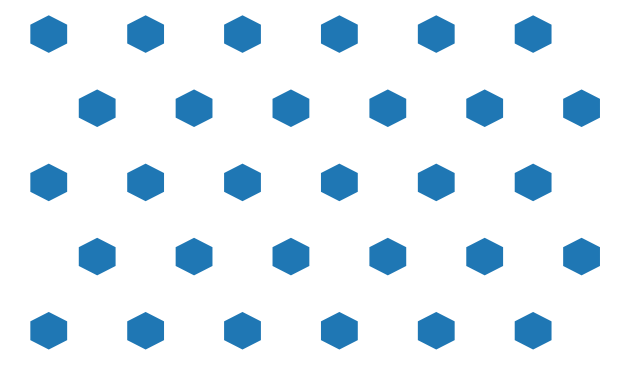

In [176]:
from simpsom.plots import *
nei = Neighborhoods(np, 6, 6, 'hexagons', PBC=True)
coords = nei.coordinates
factor = 2.5
fig, ax = plt.subplots(figsize=(8, 8 / np.sqrt(3)))
patches = []
for coord in coords:
    patches.append(tile("hexagons", coord * factor, color=[.5, .5, .5]))
pc = PatchCollection(patches)
ax.add_collection(pc)
ax.set_xlim([-1, 6 * factor])
ax.set_ylim([-1, 6.5 * factor / np.sqrt(3)])
ax.set_axis_off()

In [177]:
np.sqrt(3) / 4

0.4330127018922193

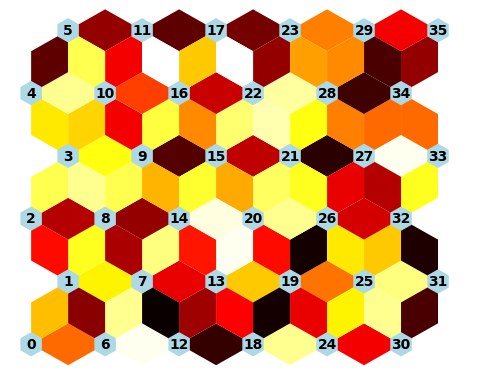

In [178]:
from simpsom.plots import *
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, Polygon
from matplotlib.collections import PatchCollection
nei = Neighborhoods(np, 6, 6, 'hexagons', PBC=False)
coords = nei.coordinates
factor = 3.5
polygon = RegularPolygon(
    (0, 0),
    numVertices=6,
    radius=factor / np.sqrt(3),
    orientation=np.radians(0),
    color='grey',
)
vertices = np.vstack([polygon.get_verts()[:-1], [[0, 0]]]).copy()
zerocoord = vertices[3]
idxs = [
    [0, 1, 6, 5, 0],
    [5, 6, 3, 4, 5],
    [1, 2, 3, 6, 1],
]
basepolygons = []
for i, idxs_ in enumerate(idxs):
    verts = np.asarray([vertices[idx] for idx in idxs_])
    if i == 0:
        verts = verts + np.asarray([0.5 * factor, - 1.5 *  factor / np.sqrt(3)])[None, :]
    polygon_ = Polygon(verts)
    basepolygons.append(polygon_)
lookup_table = np.full((nei.n_nodes, 3), -1)
all_pairwise = np.random.rand(nei.n_nodes, nei.n_nodes)
connectors = []
connector_array = []
dx = coords[:, 0, None] - coords[:, None, 0]
dy = coords[:, 1, None] - coords[:, None, 1]
for i, coord in enumerate(coords):
    right = (nei.dx[i] == 1) & (nei.dy[i] == 0)
    js = np.where(right)[0]
    if len(js) == 1:
        lookup_table[i, 0] = js[0]
    topright = (nei.dx[i] == 0) & (nei.dy[i] == 1)
    js = np.where(topright)[0]
    if len(js) == 1:
        lookup_table[i, 1] = js[0]
    topleft = (nei.dx[i] == -1) & (nei.dy[i] == 1)
    js = np.where(topleft)[0]
    if len(js) == 1:
        lookup_table[i, 2] = js[0]
for i, lt in enumerate(lookup_table):
    for k, j in enumerate(lt):
        if j == -1:
            continue
        basepoly = basepolygons[k]
        offset = factor * coords[i] - zerocoord
        newpoly = Polygon(basepoly.get_verts() + offset)
        connectors.append(newpoly)
        connector_array.append(all_pairwise[i, j])
connectors = PatchCollection(connectors, cmap=colormaps.matlab_hot, norm=Normalize(0, 1))
connectors.set_array(connector_array)
fig, ax = plt.subplots(figsize=(6, 8 / np.sqrt(3)))
patches = []
for i, coord in enumerate(coords):
    patches.append(tile("hexagons", coord * factor, color=[0, 0, 0]))
    ax.text(*(coord * factor), str(i), ha="center", va="center", fontsize=10, color="black", fontweight="bold")
pc = PatchCollection(patches, color="lightblue")
ax.set_xlim([-1, 6 * factor])
ax.set_ylim([-1, 8 * factor / np.sqrt(3)])
ax.set_axis_off()
ax.add_collection(connectors)
ax.add_collection(pc)

# SOM pretty plots

In [179]:
nei = Neighborhoods(np, 10, 10, 'hexagons', PBC=False)
othernei = Neighborhoods(np, 6, 6, 'hexagons', PBC=True)
coords = nei.coordinates
othercoords = othernei.coordinates
indices = np.arange(len(coords))
outermask = (
    (indices // nei.height < 2) | 
    (indices // nei.height > nei.height - 3) | 
    (indices % nei.width < 2) | 
    (indices % nei.width > nei.width - 3)
)
grid1 = np.arange(nei.width * nei.height).reshape(nei.height, nei.width, order='F')
grid2  = np.arange(othernei.width * othernei.height).reshape(othernei.height, othernei.width, order='F')
theslice = slice(grid2.shape[0] - 2, grid2.shape[0] - 2 + grid1.shape[0])
grid1[:, :2] = np.tile(grid2[:, -2:].T, 3)[:, theslice].T
grid1[:, -2:] = np.tile(grid2[:, :2].T, 3)[:, theslice].T
grid1[:2, :] = np.tile(grid2[-2:, :], 3)[:, theslice]
grid1[-2:, :] = np.tile(grid2[:2, :], 3)[:, theslice]
grid1 = grid1.flatten(order='F')
grid1[~outermask] = grid2.flatten(order='F')

(0.7320507764816284, 7.062177658081055)

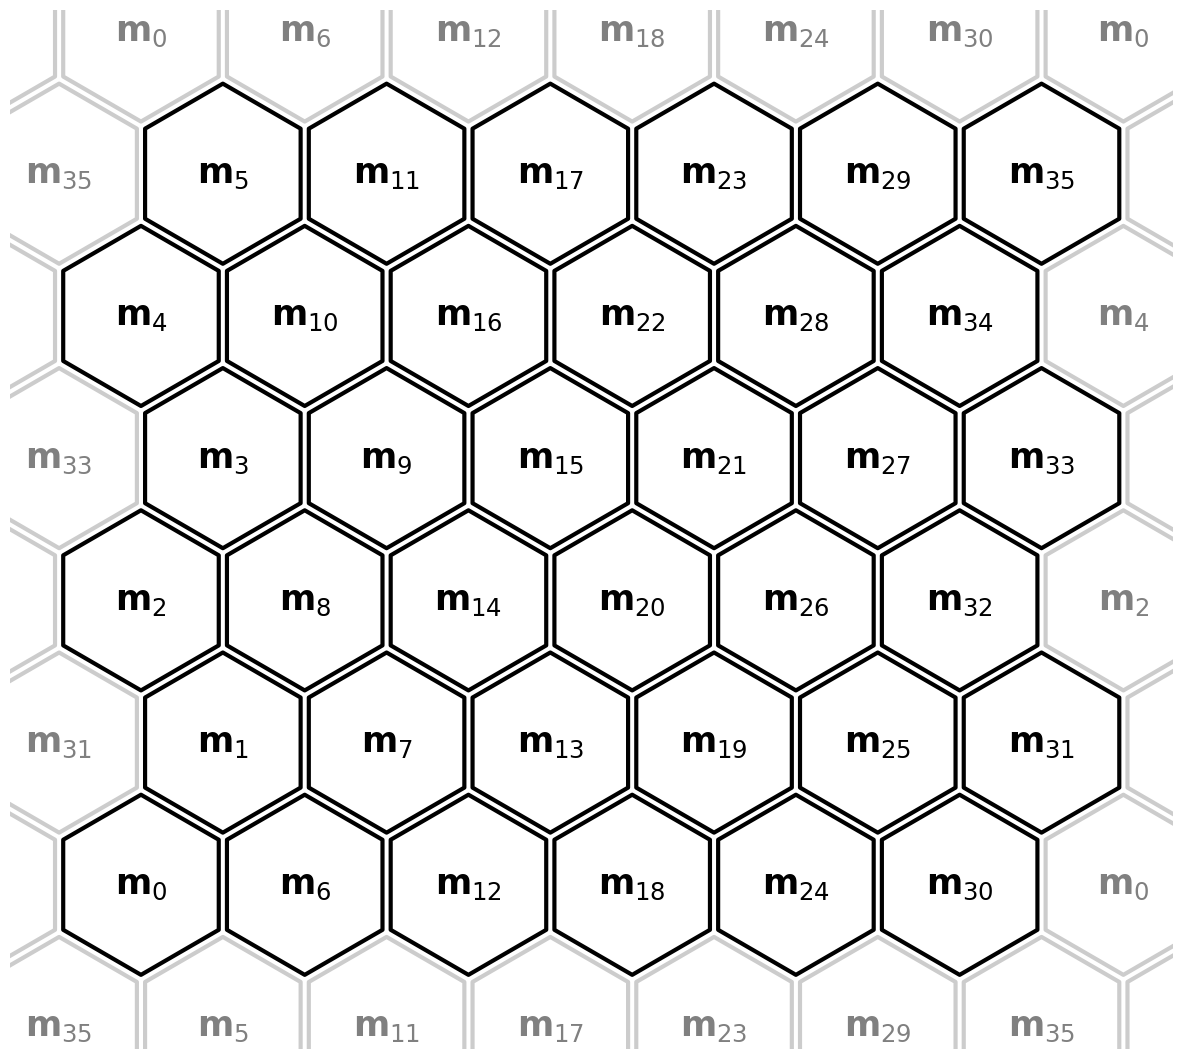

In [180]:
edgecolors = np.full(len(coords), 'black', dtype=object)
edgecolors[outermask] = 'gray'
alphas = np.ones(len(coords))
alphas[outermask] = 0.2
fig, ax = splots.plot_map(
    coords, np.ones(len(coords)), 'hexagons', 
    draw_cbar=False, figsize=(15, 13.5), 
    show=False, edgecolors = 'black', cmap='Greys',
    alphas=alphas, linewidths=3,
)
xlims = [np.amin(coords[~outermask][:, 0]) - 0.8, np.amax(coords[~outermask][:, 0]) + 0.8]
ylims = [np.amin(coords[~outermask][:, 1]) - 1, np.amax(coords[~outermask][:, 1]) + 1]
for i, c in enumerate(coords):
    x, y = c
    if x > xlims[0] and x < xlims[-1] and y > ylims[0] and y < ylims[-1]: 
        ax.text(x, y, r'$\mathbf{m}_{' + f'{grid1[i]}' + r'}$', va='center', ha='center', color=edgecolors[i])
ax.set_xlim(xlims)
ax.set_ylim(ylims)

KeyboardInterrupt: 

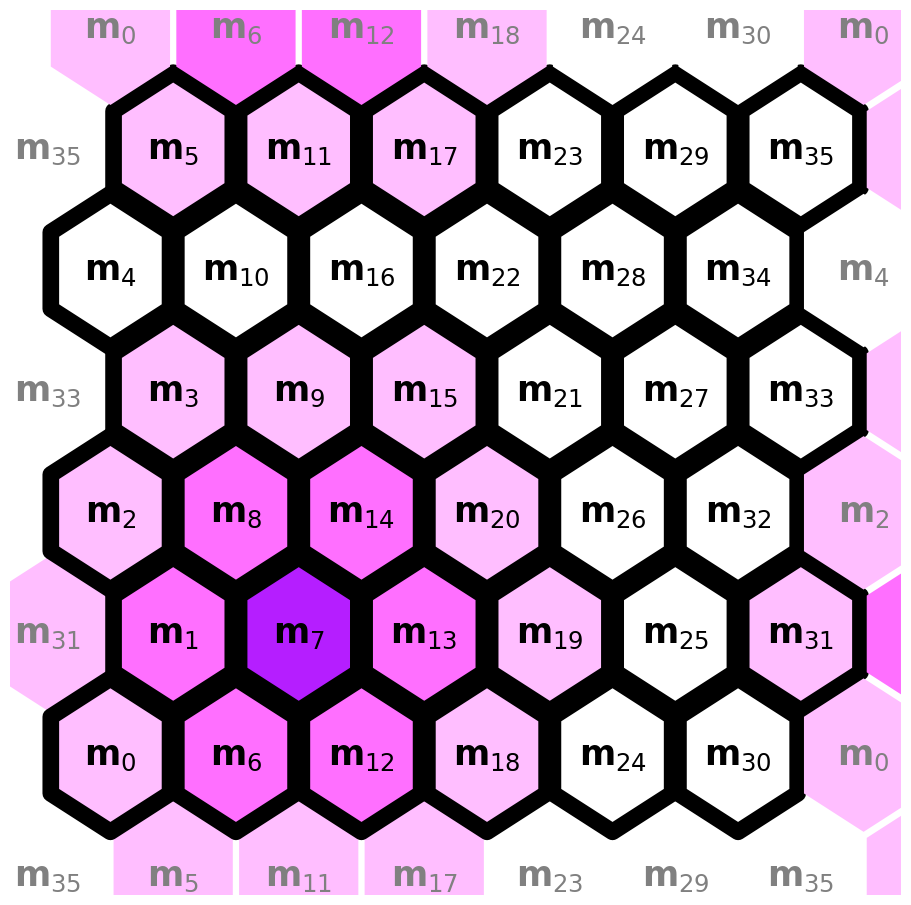

In [181]:
import colormaps
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize
from jetstream_hugo.definitions import FIGURES
nei_caller = othernei.neighborhood_caller(7, .8, 'gaussian')[grid1]
# nei_caller[outermask] /= 5
alphas[outermask] = 0.0001
colors = np.vstack((np.ones((1, 4)), colormaps.cet_l_bmw1_r(np.linspace(0.1, 0.5, 100))))
cmap = LinearSegmentedColormap.from_list('my_colormap', colors)
norm = Normalize(0, 1)
fig, ax = splots.plot_map(coords, nei_caller, 'hexagons', draw_cbar=False, figsize=(11.5, 11.5), show=False, edgecolors=edgecolors, cmap=cmap, alphas=alphas, linewidths=12.)
xlims = [np.amin(coords[~outermask][:, 0]) - 0.8, np.amax(coords[~outermask][:, 0]) + 0.8]
ylims = [np.amin(coords[~outermask][:, 1]) - 1, np.amax(coords[~outermask][:, 1]) + 1]
for i, c in enumerate(coords):
    x, y = c
    if x > xlims[0] and x < xlims[-1] and y > ylims[0] and y < ylims[-1]: 
        t = r'$\mathbf{m}_{' + f'{grid1[i]}' + r'}$'
        ax.text(x, y, r'$\mathbf{m}_{' + f'{grid1[i]}' + r'}$', va='center', ha='center', color=edgecolors[i])
ax.set_xlim(xlims)
ax.set_ylim(ylims)
fig.savefig(f'{FIGURES}/som_demo.png', dpi=300, bbox_inches='tight')

# Jet detection demo

In [2]:
t = 202
ds = xr.Dataset()
ds["s"] = open_da("ERA5", "plev", "s", "6H", 1999, "JJA", -80, 30, 20, 80)[t].load()
ds["u"] = open_da("ERA5", "plev", "u", "6H", 1999, "JJA", -80, 30, 20, 80)[t].load()
ds["v"] = open_da("ERA5", "plev", "v", "6H", 1999, "JJA", -80, 30, 20, 80)[t].load()

In [ ]:
def this_cc(da):
    da = this_smooth(da)
    filtered = sato(da / da.max(), black_ridges=False, sigmas=range(3, 6))
    filtered = filtered / filtered.max()
    return da * filtered

this_smooth = partial(smooth, smooth_map={"lon+lat": ("fft", 0.15)})

ds["s_smo"] = this_smooth(ds["s"])
ds["u_smo"] = this_smooth(ds["u"])
ds["v_smo"] = this_smooth(ds["v"])
ds["criterion"] = this_cc(ds["s"])

## Raw data

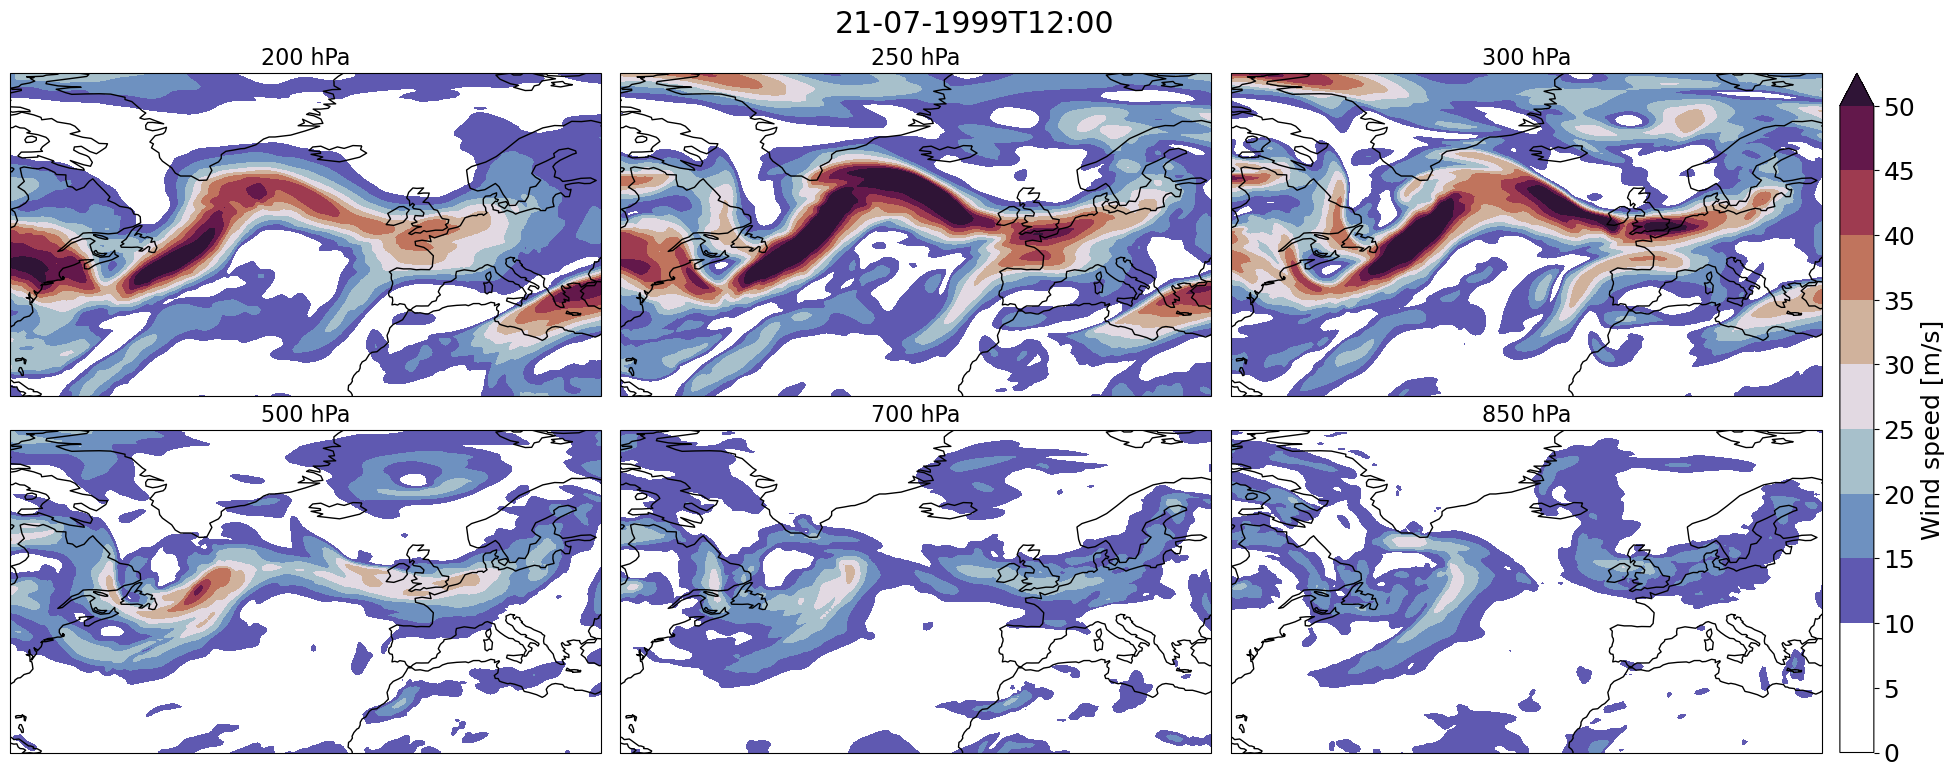

In [ ]:
clu = Clusterplot(2, 3, get_region(ds))
titles = [f"{lev} hPa" for lev in ds.lev.values]
_ = clu.add_contourf(ds["s"], cmap="twilight_shifted", transparify=2, nlevels=11, titles=titles, cbar_kwargs={"label": "Wind speed [m/s]", "pad": 0.01})
clu.fig.suptitle(ds.time.dt.strftime("%d-%m-%YT%H:00").item())
clu.resize_relative([1, 1.08])

## Smooth

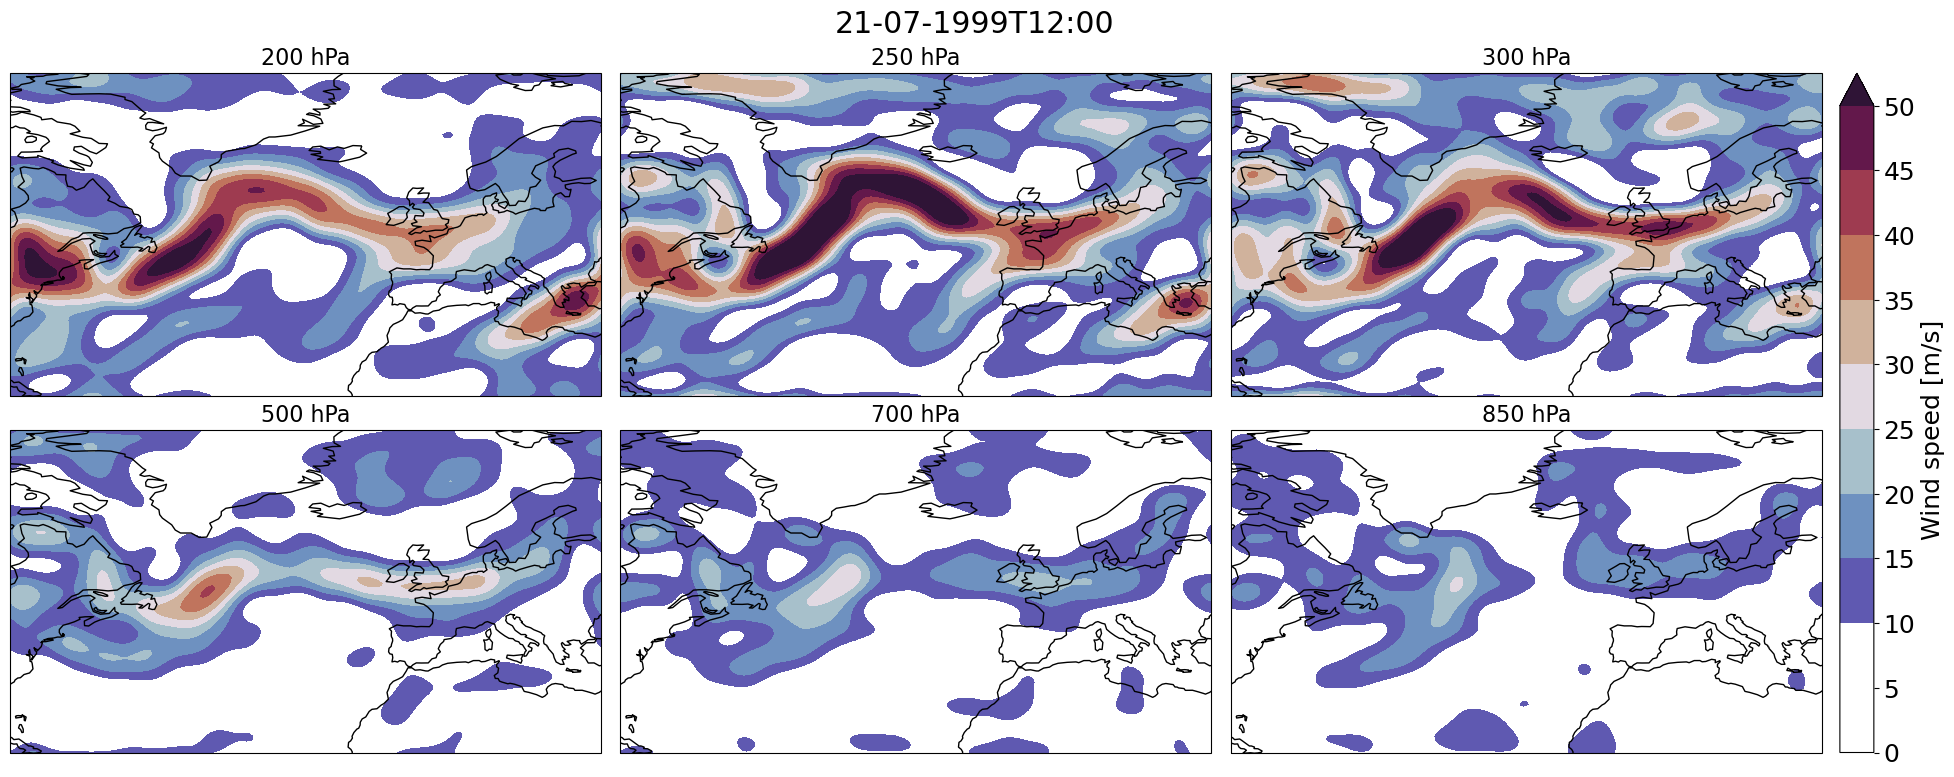

In [ ]:
clu = Clusterplot(2, 3, get_region(ds))
titles = [f"{lev} hPa" for lev in ds.lev.values]
_ = clu.add_contourf(ds["s_smo"], cmap="twilight_shifted", transparify=2, nlevels=11, titles=titles, cbar_kwargs={"label": "Wind speed [m/s]", "pad": 0.01})
clu.fig.suptitle(ds.time.dt.strftime("%d-%m-%YT%H:00").item())
clu.resize_relative([1, 1.08])

## Vesselness

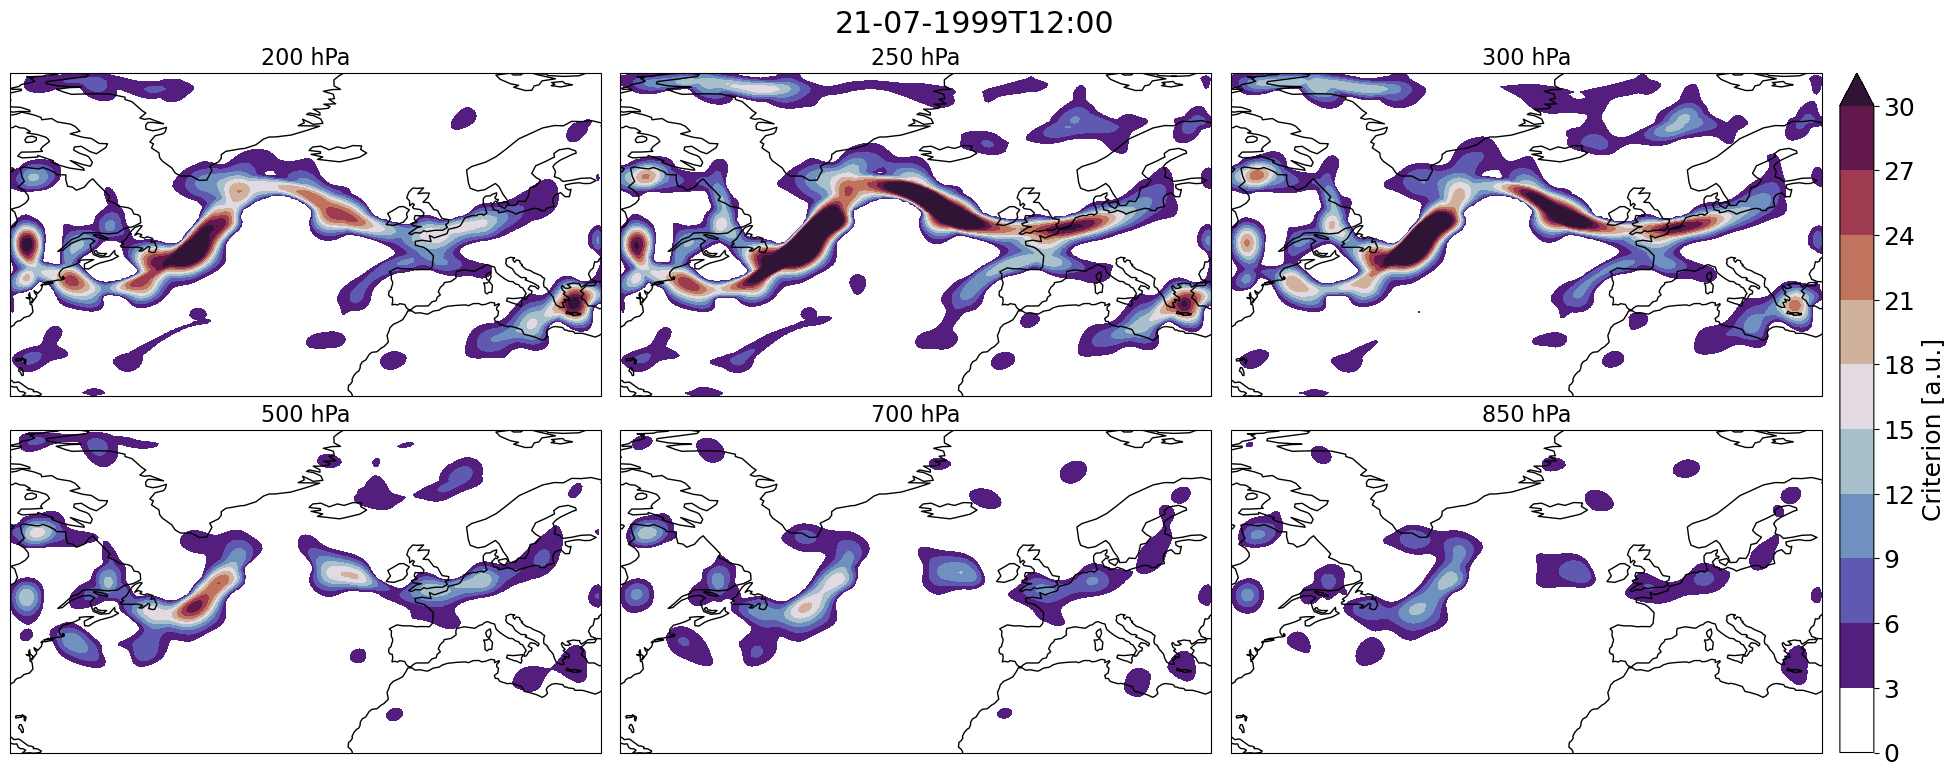

In [ ]:
clu = Clusterplot(2, 3, get_region(ds))
titles = [f"{lev} hPa" for lev in ds.lev.values]
_ = clu.add_contourf(ds["criterion"], cmap="twilight_shifted", transparify=1, nlevels=11, titles=titles, cbar_kwargs={"label": "Criterion [a.u.]", "pad": 0.01})
clu.fig.suptitle(ds.time.dt.strftime("%d-%m-%YT%H:00").item())
clu.resize_relative([1, 1.08])

## Flatten

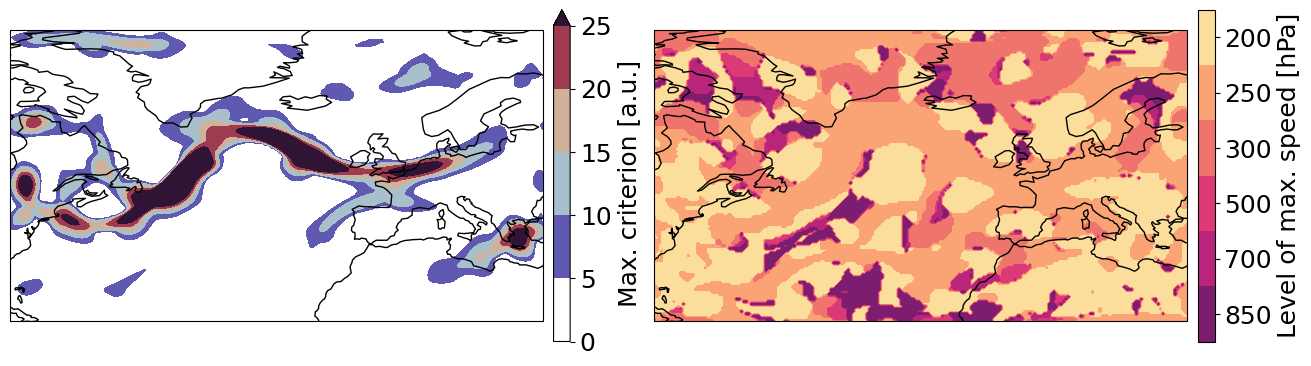

In [ ]:
ds_flat = flatten_by(ds, "criterion")
clu = Clusterplot(1, 2, get_region(ds))
lon, lat = ds_flat.lon.values, ds_flat.lat.values
kwargs1, cbar_kwargs1, im1, _ = clu.setup_contourf([ds_flat["criterion"]], cmap="twilight_shifted", transparify=1, q=.96, nlevels=6, cbar_kwargs={"label": "Max. criterion [a.u.]", "pad": 0.02})
clu.axes[0].contourf(lon, lat, ds_flat["criterion"].values, **kwargs1)
lev = ds_flat["lev"].values
ulev = np.unique(lev)
for i, l in enumerate(ulev):
    lev[lev == l] = i    
im2 = clu.axes[1].contourf(lon, lat, lev, transform=ccrs.PlateCarree(), levels=np.arange(-0.5, 6.5, 1), cmap=colormaps.sunsetdark)
clu.fig.colorbar(im1, ax=clu.axes[0], **cbar_kwargs1)
cbar2 = clu.fig.colorbar(im2, ax=clu.axes[1], label="Level of max. speed [hPa]", pad=0.02)
cax = cbar2.ax
cax.set_yticks(np.arange(6), ulev)
cax.invert_yaxis()


## Mask

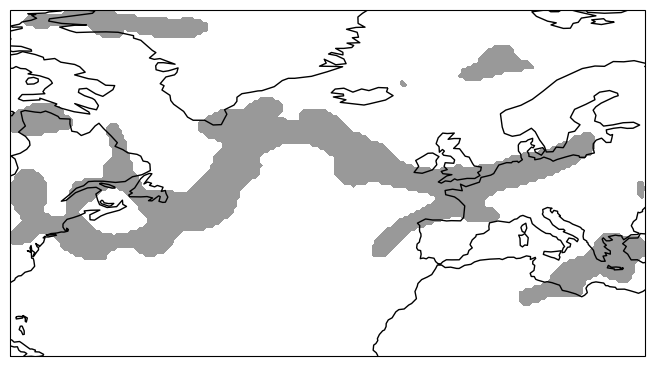

In [ ]:
clu = Clusterplot(1, 1, get_region(ds))
_ = clu.add_contourf([ds_flat["criterion"] > 7.5], alpha=0.4, draw_cbar=False)

## Clustering

In [ ]:
groups, dist_mats = cluster_generic(
    ds_flat["criterion"],
    ds_flat["s"],
    ds_flat["s_smo"],
    ds_flat["lev"],
    ds_flat["u"],
    ds_flat["v"],
    criterion_threshold=7.5,
    distance_threshold=1.5,
    min_size=400,
)

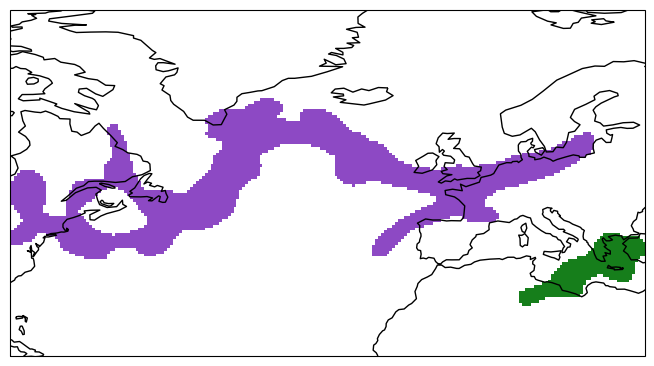

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
from jetstream_hugo.plots import make_transparent
from jetstream_hugo.plots import COLORS5

clu = Clusterplot(1, 1, get_region(ds))
ax = clu.axes[0]
da = ds_flat["s"].copy(data=np.zeros(ds_flat["s"].shape, dtype=int))
for i, group in enumerate(groups):
    x = xr.DataArray(group["lon"], dims="points")
    y = xr.DataArray(group["lat"], dims="points")
    da.loc[y, x] = i + 1
cmap = LinearSegmentedColormap.from_list(
    "demo_cmap",
    [[0, 0, 0, 0], COLORS5[1], COLORS5[0]]
)
ax.pcolormesh(lon, lat, da, cmap=cmap)

## Shortest path

In [ ]:
from jetstream_hugo.jet_finding import jets_from_mask
jets = jets_from_mask(groups, dist_mats, jet_cutoff=1e7)

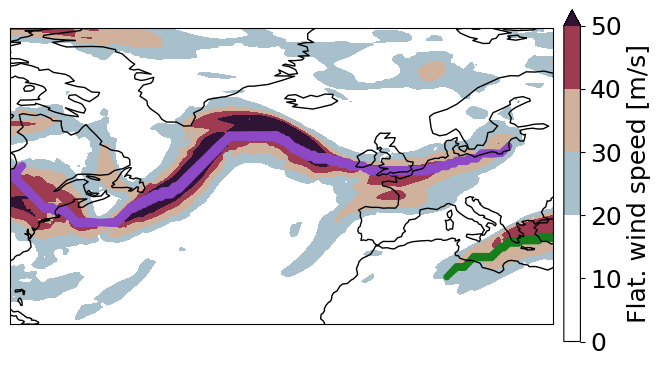

In [ ]:
clu = Clusterplot(1, 1, get_region(ds))
clu.add_contourf([ds_flat["s"]], cmap="twilight_shifted", transparify=2, q=.96, nlevels=6, cbar_kwargs={"label": "Flat. wind speed [m/s]", "pad": 0.02})
ax = clu.axes[0]
for i, jet in enumerate(jets):
    x, y, s = jet[["lon", "lat", "s"]].to_numpy().T
    ax.scatter(x, y, s=s * 3, c=COLORS5[1 - i], marker=".")

# Demo 2, flatten first, no cbar

In [55]:
def open_ds():
    ds = xr.Dataset()
    ds["s"] = open_da("ERA5", "plev", "s", "6H", 2000, [1], -80, 30, 20, 80, [200, 250, 300]).load()
    ds["u"] = open_da("ERA5", "plev", "u", "6H", 2000, [1], -80, 30, 20, 80, [200, 250, 300]).load()
    ds["v"] = open_da("ERA5", "plev", "v", "6H", 2000, [1], -80, 30, 20, 80, [200, 250, 300]).load()
    return ds

ds_ = open_ds()

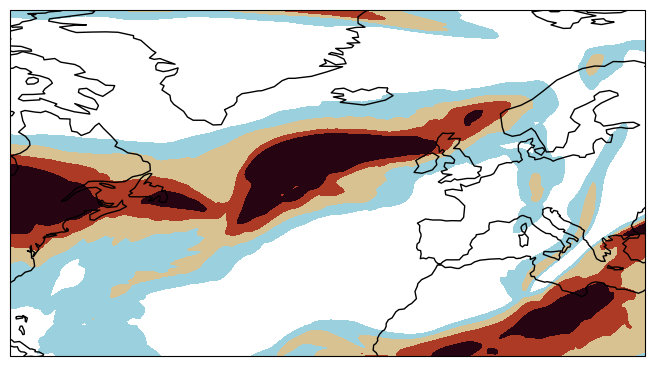

In [56]:
this_smooth = partial(smooth, smooth_map={"lon+lat": ("fft", 0.15)})

def this_cc(da):
    da = this_smooth(da)
    filtered = sato(da / da.max(), black_ridges=False, sigmas=range(3, 6))
    filtered = filtered / filtered.max()
    return da * filtered

ds = ds_.isel(time=4)
ds = flatten_by(ds, "s")

for varname in ["s", "u", "v"]:
    ds[f"{varname}_smo"] = this_smooth(ds[varname])
ds["criterion"] = this_cc(ds["s"])
clu = Clusterplot(1, 1, get_region(ds))
_ = clu.add_contourf([ds["s"]], cmap=colormaps.fusion_r, q=0.91, transparify=2, nlevels=6, draw_cbar=False)

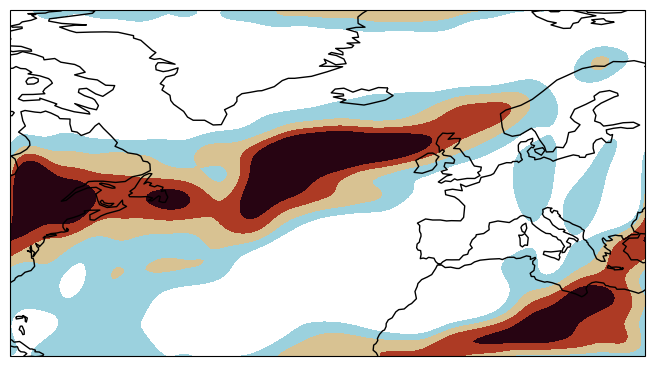

In [57]:
clu = Clusterplot(1, 1, get_region(ds))
_ = clu.add_contourf([ds["s_smo"]], cmap=colormaps.fusion_r, q=0.9, transparify=2, nlevels=6, draw_cbar=False)

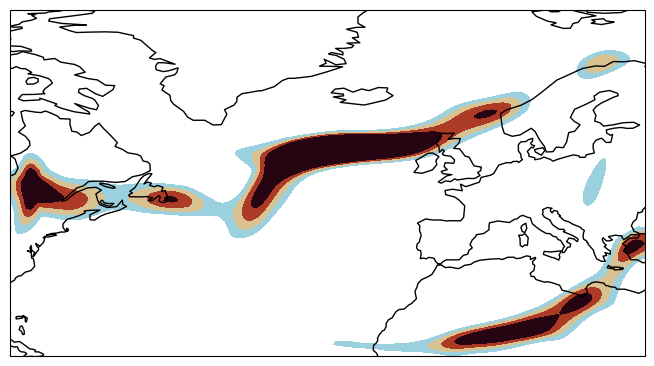

In [58]:
clu = Clusterplot(1, 1, get_region(ds))
_ = clu.add_contourf([ds["criterion"]], cmap=colormaps.fusion_r, q=0.96, transparify=2, nlevels=6, draw_cbar=False)

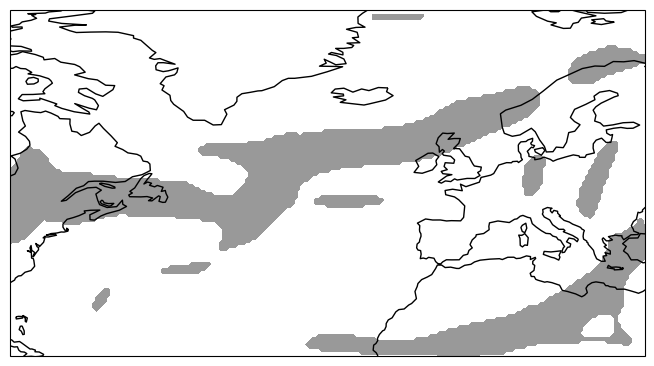

In [59]:
clu = Clusterplot(1, 1, get_region(ds))
_ = clu.add_contourf([ds["criterion"] > 7.5], draw_cbar=False, alpha=0.4, cmap=colormaps.greys)

In [60]:
groups, dist_mats = cluster_generic(
    ds["criterion"],
    ds["s"],
    ds["s_smo"],
    ds["criterion"],
    ds["lev"],
    ds["u"],
    ds["v"],
    criterion_threshold=7.5,
    distance_threshold=1.5,
    min_size=400,
)

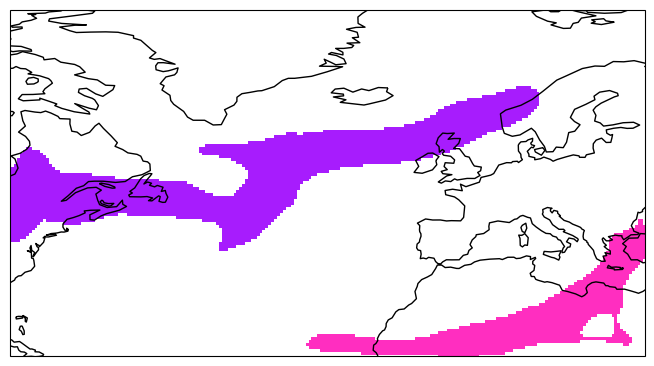

In [61]:

clu = Clusterplot(1, 1, get_region(ds))
ax = clu.axes[0]
da = ds["s"].copy(data=np.zeros(ds["s"].shape, dtype=int))
lon, lat = da.lon.values, da.lat.values
for i, group in enumerate(groups):
    x = xr.DataArray(group["lon"], dims="points")
    y = xr.DataArray(group["lat"], dims="points")
    da.loc[y, x] = i + 1
cmap = LinearSegmentedColormap.from_list(
    "demo_cmap",
    [[0, 0, 0, 0], COLORS[2], COLORS[1]]
)
ax.pcolormesh(lon, lat, da, cmap=cmap)

In [62]:
jets = jets_from_mask(groups, dist_mats, jet_cutoff=1e7)

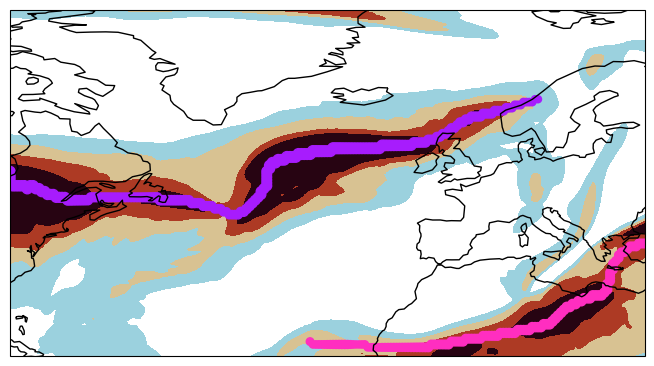

In [63]:
clu = Clusterplot(1, 1, get_region(ds))
clu.add_contourf([ds["s"]], transparify=2, q=.90, nlevels=6, draw_cbar=False)
ax = clu.axes[0]
for i, jet in enumerate(jets):
    x, y, s = jet[["lon", "lat", "s"]].to_numpy().T
    ax.scatter(x, y, s=s * 3, c=COLORS[2 - i], marker=".")

## Tracking

In [64]:
this_smooth = partial(smooth, smooth_map={"lon+lat": ("fft", 0.15)})

def this_cc(da):
    da = this_smooth(da)
    filtered = sato(da / da.max(), black_ridges=False, sigmas=range(3, 6))
    filtered = filtered / filtered.max()
    return da * filtered

def fast_find_jets(ds):
    ds = flatten_by(ds, "s")
    for varname in ["s", "u", "v"]:
        ds[f"{varname}_smo"] = this_smooth(ds[varname])
    ds["criterion"] = this_cc(ds["s"])
    groups, dist_mats = cluster_generic(
        ds["criterion"],
        ds["s"],
        ds["s_smo"],
        ds["criterion"],
        ds["lev"],
        ds["u"],
        ds["v"],
        criterion_threshold=7.5,
        distance_threshold=1.5,
        min_size=400,
    )
    jets = jets_from_mask(groups, dist_mats, jet_cutoff=4e7)
    return jets

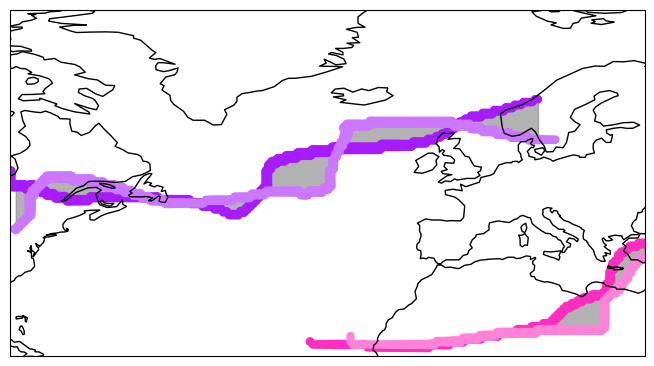

In [65]:
t = 4
ds1, ds2 = ds_.isel(time=t), ds_.isel(time=t + 2)
jets1, jets2 = fast_find_jets(ds1), fast_find_jets(ds2)
clu = Clusterplot(1, 1, get_region(ds))
ax = clu.axes[0]
for (jet1, jet2) in [(jets1[0], jets2[0]), (jets1[1], jets2[1])]:
    common_x, idx_1, idx_2 = np.intersect1d(jet1["lon"], jet2["lon"], return_indices=True)
    ax.fill_between(common_x, jet1.iloc[idx_1, 1], jet2.iloc[idx_2, 1], color='grey', alpha=0.6)
for i, jet in enumerate(reversed(jets1)):
    x, y, s = jet[["lon", "lat", "s"]].to_numpy().T
    ax.scatter(x, y, s=s * 3, color=COLORS_EXT[3 + 3 * i + 1], marker=".")
for i, jet in enumerate(reversed(jets2)):
    x, y, s = jet[["lon", "lat", "s"]].to_numpy().T
    ax.scatter(x, y, s=s * 3, color=COLORS_EXT[3 + 3 * i], marker=".")

## Graph

In [66]:
from jetstream_hugo.jet_finding import compute_weights, create_graph, normalize_points_for_weights
import matplotlib.pyplot as plt
import networkx as nx
group, dist_mat = groups[1], dist_mats[1]
xlim = [-45, -30]
ylim = [40, 52]
mask = (group["lon"].to_numpy() > xlim[0]) & (group["lon"].to_numpy() < xlim[1])
mask = mask & (group["lat"].to_numpy() > ylim[0]) & (group["lat"].to_numpy() < ylim[1])
group, dist_mat = group[mask], dist_mat[mask, :][:, mask]
masked_weights = compute_weights(group, dist_mat)
graph = create_graph(masked_weights, dist_mat)

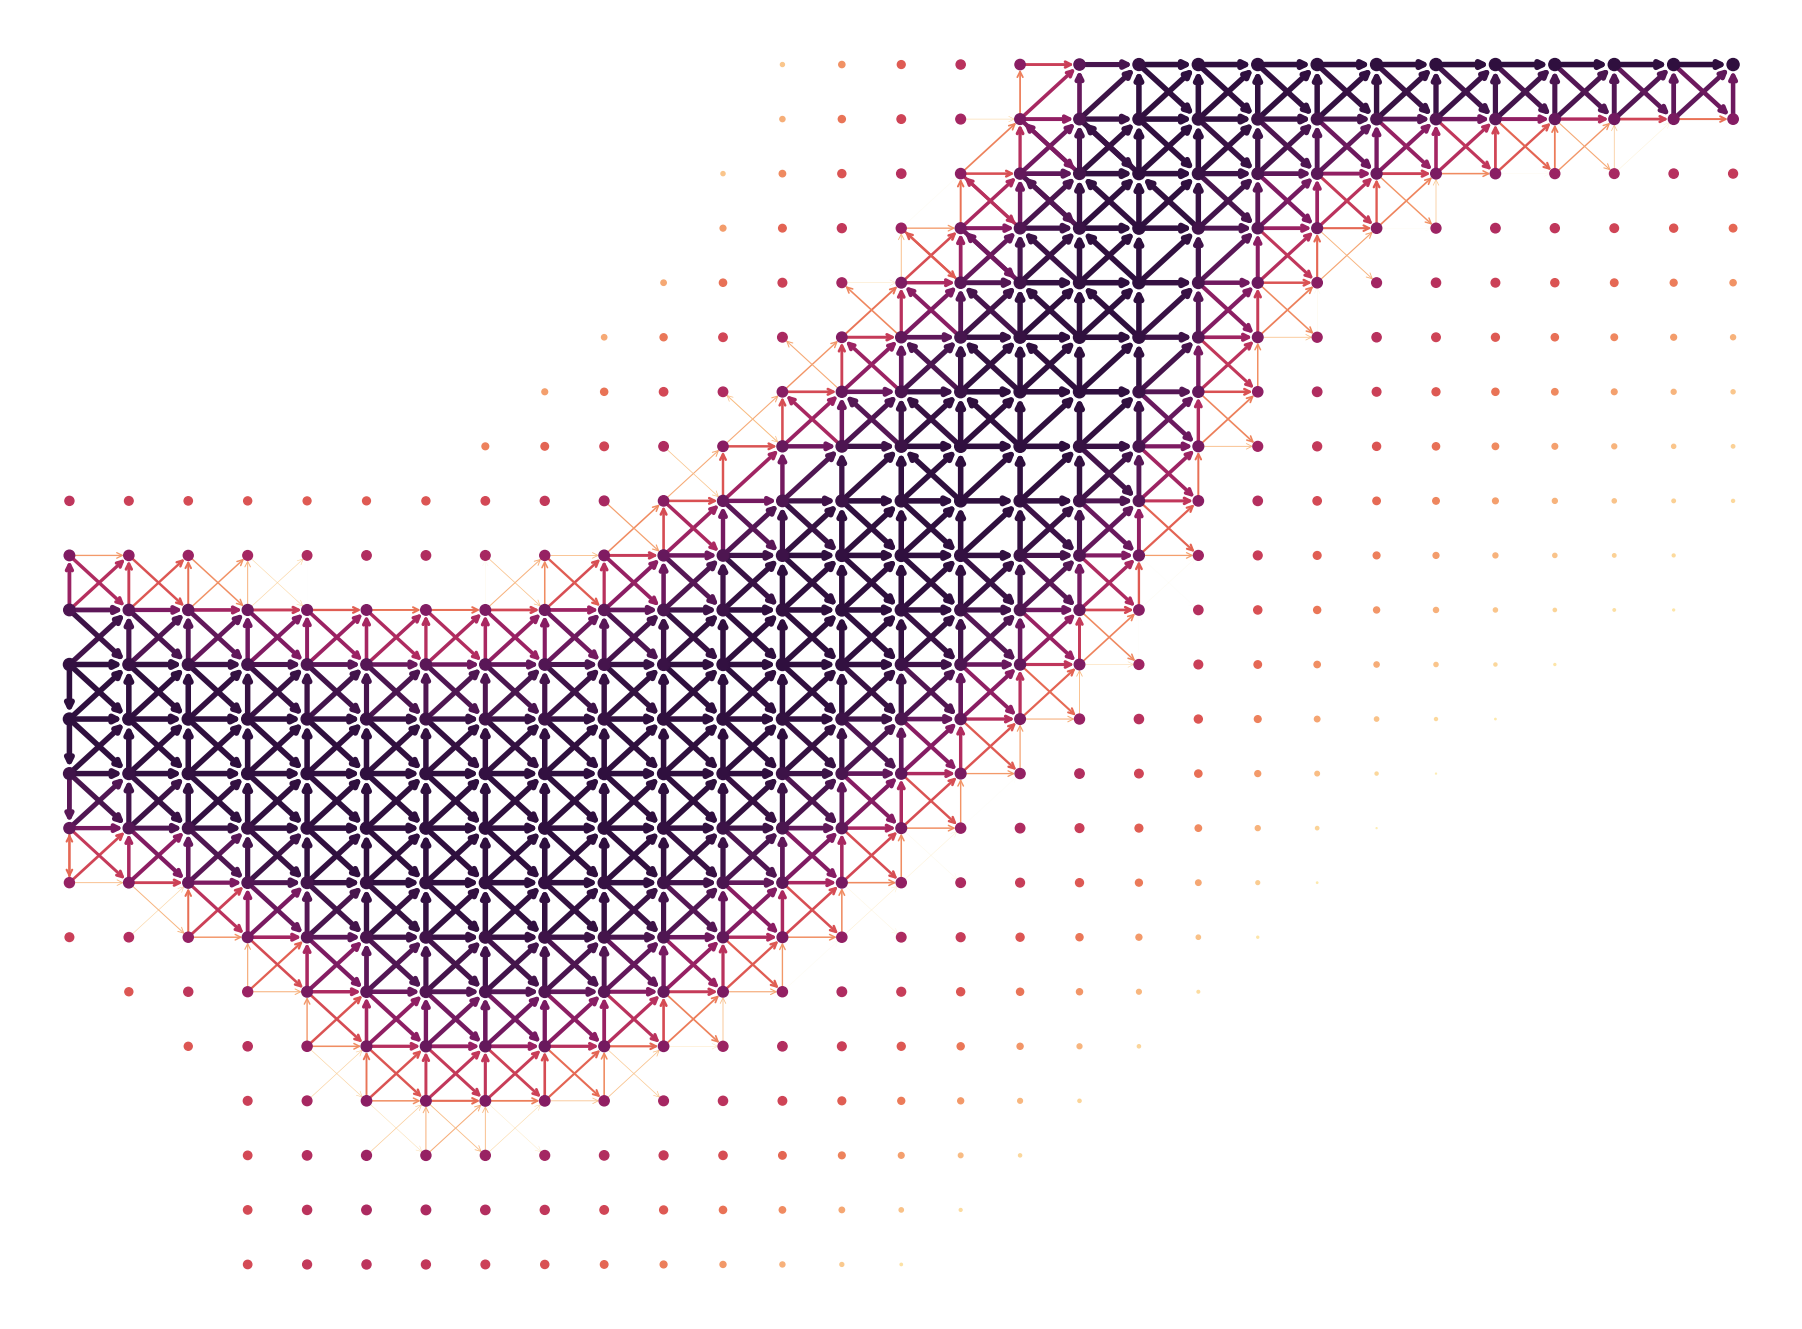

In [67]:
fig, ax = plt.subplots(figsize=(23, 17))
graph_nx = nx.DiGraph(graph)
pos = dict(zip(np.arange(np.sum(mask)), group[["lon", "lat"]].to_numpy().tolist()))
valid_edges = list(graph_nx.edges)
all_weights = np.asarray(
    [graph_nx.edges[valid_edge]["weight"] for valid_edge in valid_edges]
)
maxweight = 0.1
mask_big = all_weights < maxweight
edgelist = [valid_edges[k] for k in np.where(mask_big)[0]]
Y = maxweight - all_weights[mask_big]
edge_color = (Y - Y.min()) / (Y.max() - Y.min())
X = normalize_points_for_weights(group, "criterion")
node_color = (X - X.min()) ** 1 / (X.max() - X.min()) ** 1
_ = nx.draw_networkx(
    graph_nx,
    ax=ax,
    pos=pos,
    node_size=75 * node_color,
    cmap=colormaps.matter,
    node_color=node_color,
    edgelist=edgelist,
    edge_color=edge_color,
    width=edge_color * 4,
    arrowstyle="->",
    edge_cmap=colormaps.matter,
    edge_vmin=edge_color.min(),
    edge_vmax=edge_color.max(),
    with_labels=False,
)
ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])
limits = plt.axis("off")

In [68]:
from jetstream_hugo.clustering import Experiment
exp_for_nick = Experiment("ERA5", "plev", "u", "6H", (1990, 2000), "DJF", -60, 0, 15, 75, 850, None, None, {"time": ("win", 4 * 10)})

# Is Polar

In [69]:
mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.size"] = 14

In [70]:
exp = MultiVarExperiment("ERA5", "plev", ["u", "v", "s"], "6H", (1940, 2022), None, -80, 30, 20, 80, [200, 250, 300])
all_jets, where_are_jets, all_jets_one_array, all_jets_over_time, flags = exp.track_jets()
props_as_ds_uncat = exp.props_as_ds(False)
props_as_ds = exp.props_as_ds(True)

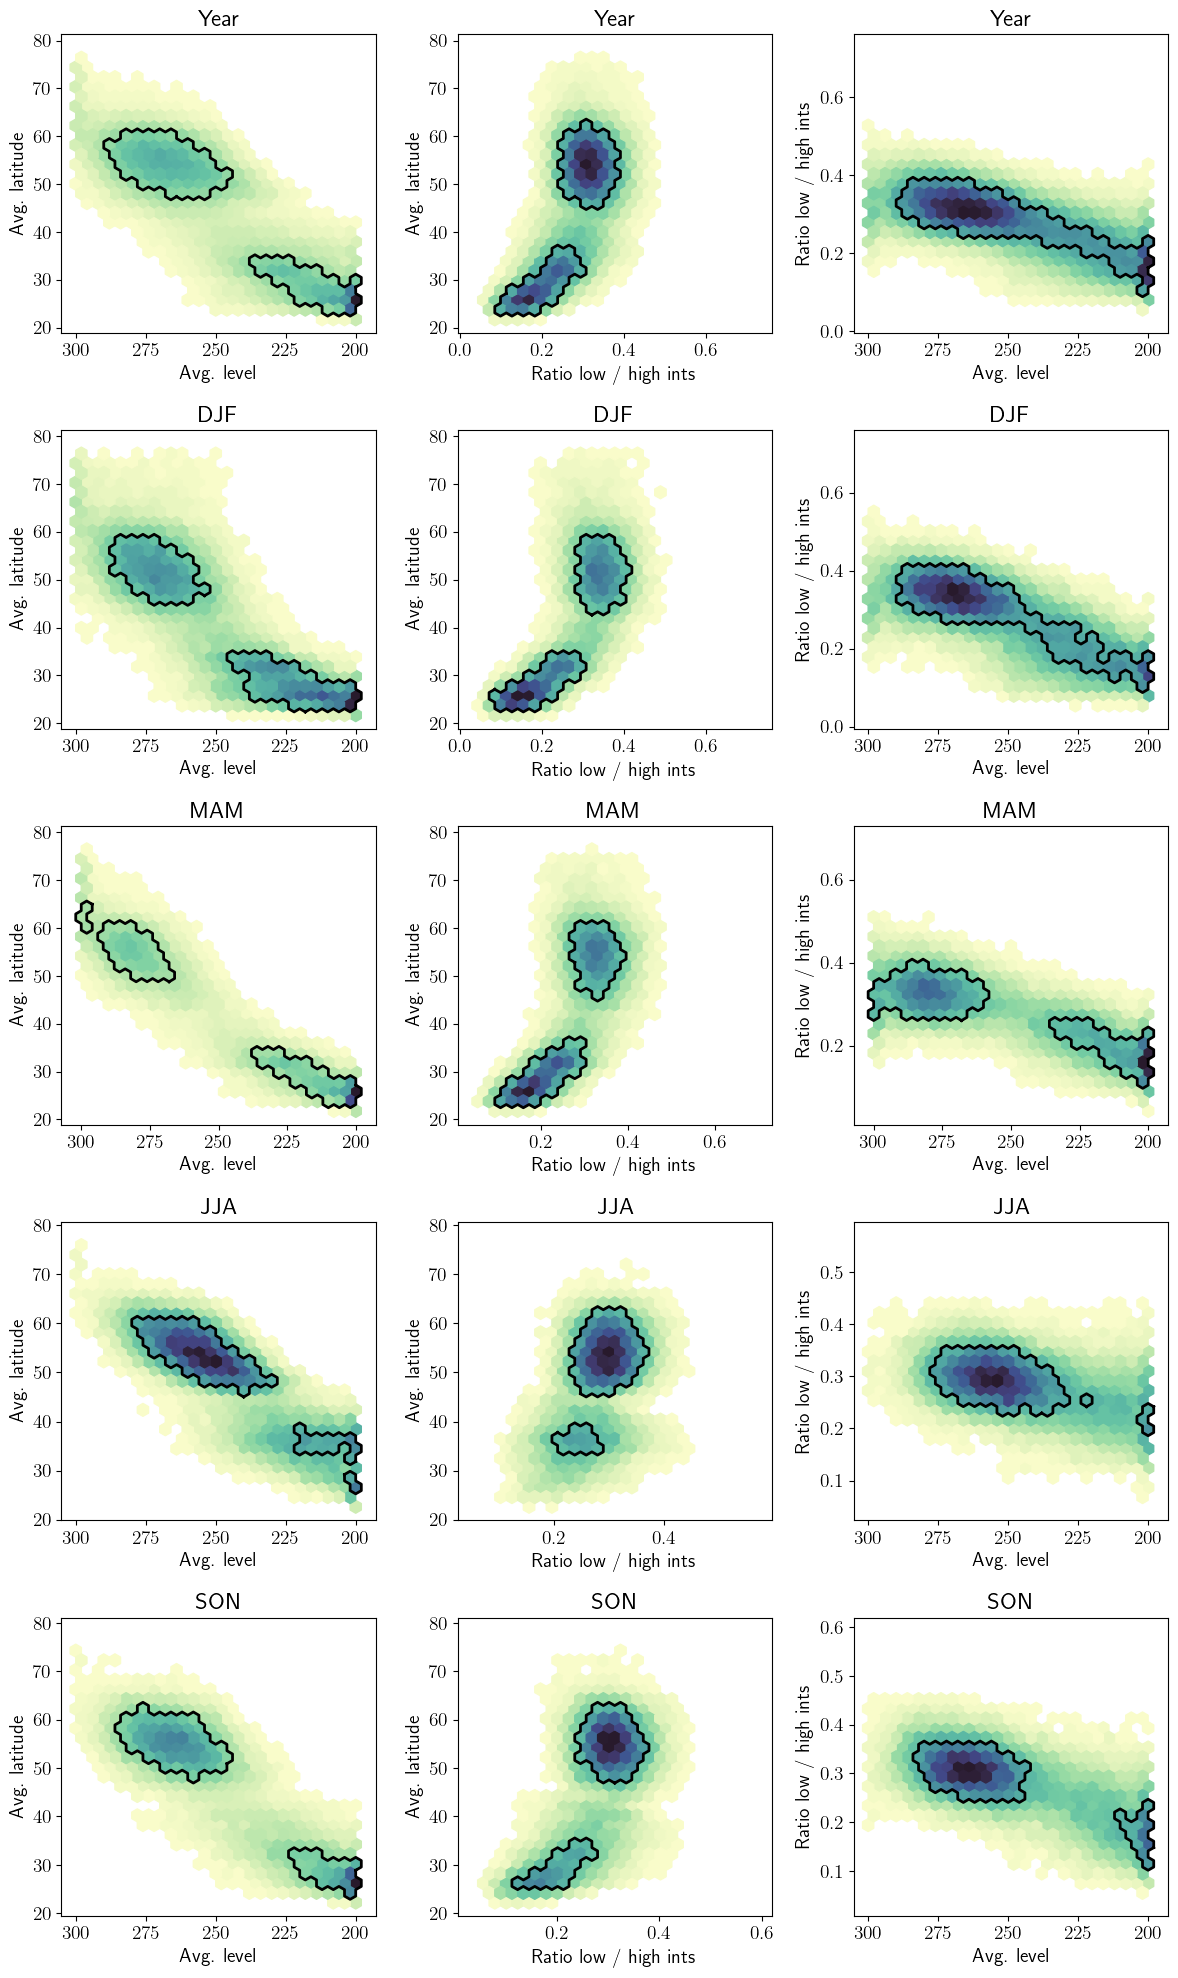

In [71]:
from shapely.geometry import Polygon
from shapely.ops import unary_union
from shapely import set_precision

fig, axes = plt.subplots(5, 3, figsize=(12, 20), tight_layout=True)
for season, axs in zip([None, "DJF", "MAM", "JJA", "SON"], axes):
    feature_names = ["mean_lat", "mean_lev", "int_ratio"]
    X, _ = extract_features(props_as_ds, feature_names, season)
    for feature_ind, ax in zip(((1, 0), (2, 0), (1, 2)), axs):
        cmap = make_transparent(colormaps.deep, nlev=100, n_transparent=1)
        im = ax.hexbin(*X[:, feature_ind].T, gridsize=25, cmap=cmap)
        try:
            ax.set_xlabel(PRETTIER_VARNAME[feature_names[feature_ind[0]]])
            ax.set_ylabel(PRETTIER_VARNAME[feature_names[feature_ind[1]]])
        except KeyError:
            ax.set_xlabel(feature_names[feature_ind[0]])
            ax.set_ylabel(feature_names[feature_ind[1]])
        offsets = im.get_offsets()
        counts = im.get_array()
        which = counts > 2.0 * counts.std()
        hex_poly = im.get_paths()[0].vertices
        hex_array = []
        for offs in offsets[which]:
            hex_array.append(set_precision(Polygon(hex_poly + offs[None, :]), 0.0001))
        polygon = unary_union(hex_array)
        try:
            ax.plot(*polygon.boundary.xy, color="black", lw=2)
        except NotImplementedError:
            for boundary in polygon.boundary.geoms:
                ax.plot(*boundary.xy, color="black", lw=2)
        if feature_names[feature_ind[0]] == "mean_lev":
            ax.invert_xaxis()
        if feature_names[feature_ind[1]] == "mean_lev":
            ax.invert_yaxis()
        ax.set_title(season if season is not None else "Year")

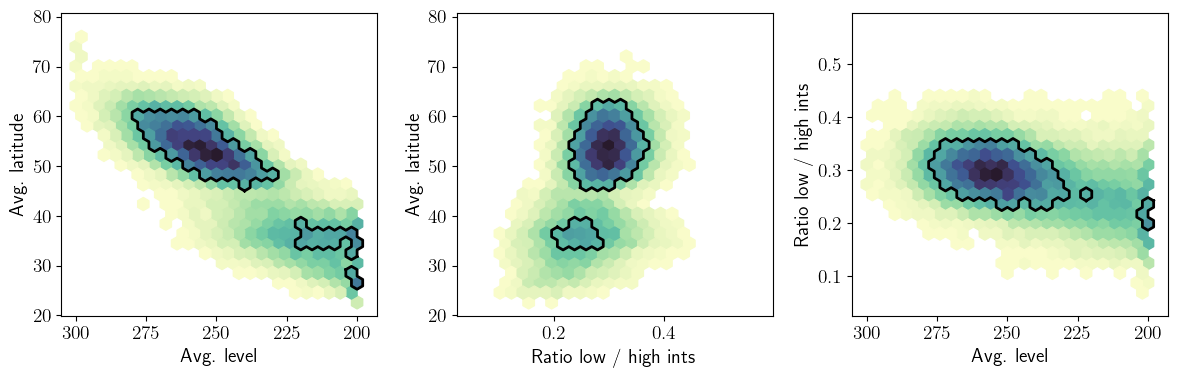

In [72]:
from shapely.geometry import Polygon
from shapely.ops import unary_union
from shapely import set_precision

fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
season = "JJA"
feature_names = ["mean_lat", "mean_lev", "int_ratio"]
X, _ = extract_features(props_as_ds, feature_names, season)
for feature_ind, ax in zip(((1, 0), (2, 0), (1, 2)), axs):
    cmap = make_transparent(colormaps.deep, nlev=100, n_transparent=1)
    im = ax.hexbin(*X[:, feature_ind].T, gridsize=25, cmap=cmap)
    try:
        ax.set_xlabel(PRETTIER_VARNAME[feature_names[feature_ind[0]]])
        ax.set_ylabel(PRETTIER_VARNAME[feature_names[feature_ind[1]]])
    except KeyError:
        ax.set_xlabel(feature_names[feature_ind[0]])
        ax.set_ylabel(feature_names[feature_ind[1]])
    offsets = im.get_offsets()
    counts = im.get_array()
    which = counts > 2.0 * counts.std()
    hex_poly = im.get_paths()[0].vertices
    hex_array = []
    for offs in offsets[which]:
        hex_array.append(set_precision(Polygon(hex_poly + offs[None, :]), 0.0001))
    polygon = unary_union(hex_array)
    try:
        ax.plot(*polygon.boundary.xy, color="black", lw=2)
    except NotImplementedError:
        for boundary in polygon.boundary.geoms:
            ax.plot(*boundary.xy, color="black", lw=2)
    if feature_names[feature_ind[0]] == "mean_lev":
        ax.invert_xaxis()
    if feature_names[feature_ind[1]] == "mean_lev":
        ax.invert_yaxis()
    # ax.set_title(season if season is not None else "Year")

Elapsed time: 2.3365 seconds
Elapsed time: 0.6288 seconds
Elapsed time: 0.6539 seconds
Elapsed time: 0.5203 seconds
Elapsed time: 0.5518 seconds


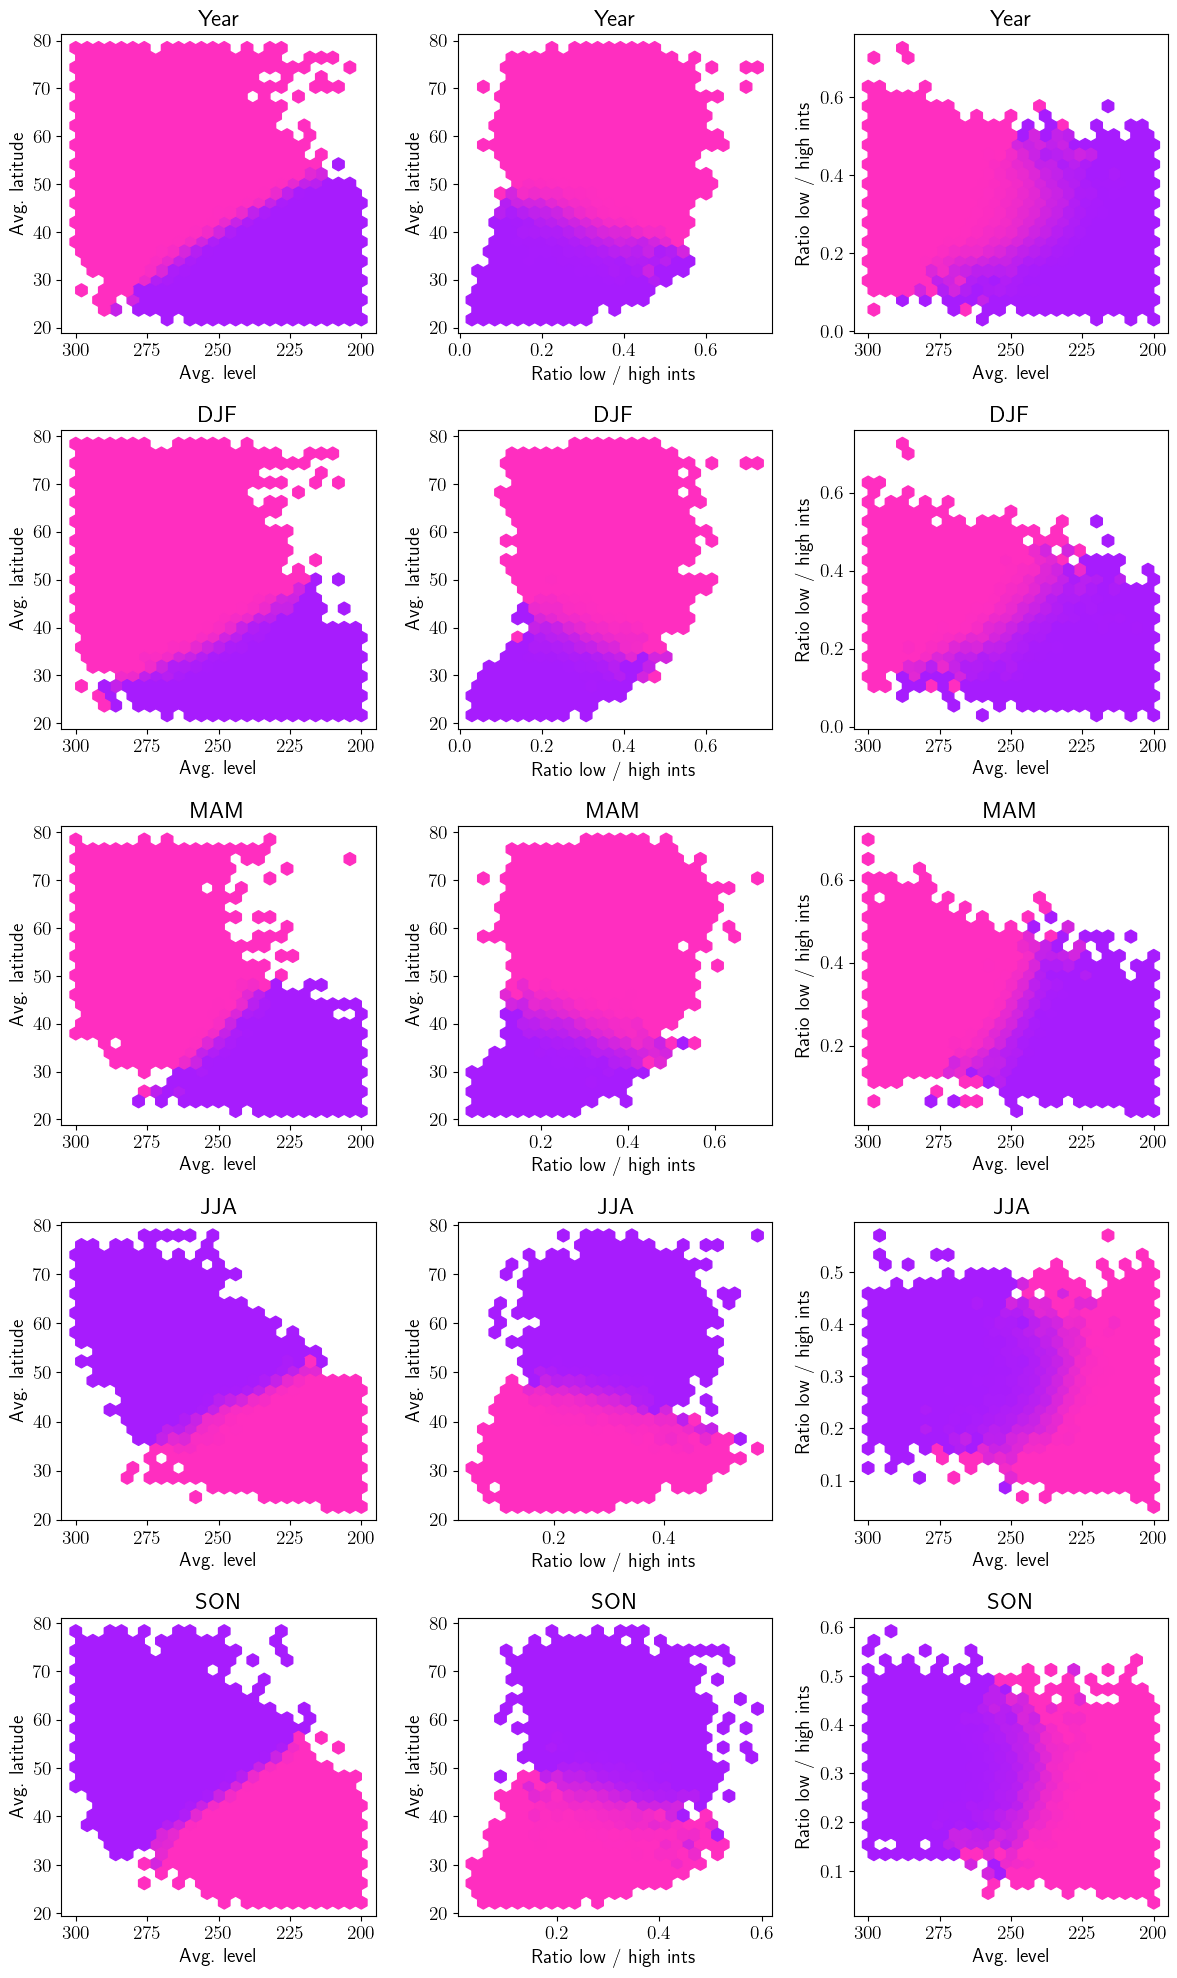

In [73]:
from matplotlib.colors import LinearSegmentedColormap
PINKPURPLE = LinearSegmentedColormap.from_list("pinkpurple", [COLORS[2], COLORS[1]])

def to_zero_one(X):
    Xmin = X.min(axis=0)
    Xmax = X.max(axis=0)
    
    return (X - Xmin[None, :]) / (Xmax - Xmin)[None, :], Xmin, Xmax


def revert_zero_one(X, Xmin, Xmax):
    return Xmin[None, :] + (Xmax - Xmin)[None, :] * X

fig, axes = plt.subplots(5, 3, figsize=(12, 20), tight_layout=True)
for season, axs in zip([None, "DJF", "MAM", "JJA", "SON"], axes):
    feature_names = ["mean_lat", "mean_lev", "int_ratio"]
    X, _ = extract_features(props_as_ds, feature_names, season)
    X, Xmin, Xmax = to_zero_one(X)
    with Timer():
        labels = Birch(threshold=0.2, n_clusters=2).fit(X).labels_
    X = revert_zero_one(X, Xmin, Xmax)
    for feature_ind, ax in zip(((1, 0), (2, 0), (1, 2)), axs):
        cmap = PINKPURPLE
        im = ax.hexbin(*X[:, feature_ind].T, gridsize=25, cmap=cmap, C=labels)
        try:
            ax.set_xlabel(PRETTIER_VARNAME[feature_names[feature_ind[0]]])
            ax.set_ylabel(PRETTIER_VARNAME[feature_names[feature_ind[1]]])
        except KeyError:
            ax.set_xlabel(feature_names[feature_ind[0]])
            ax.set_ylabel(feature_names[feature_ind[1]])
        ax.set_title(season if season is not None else "Year")
        if feature_names[feature_ind[0]] == "mean_lev":
            ax.invert_xaxis()
        if feature_names[feature_ind[1]] == "mean_lev":
            ax.invert_yaxis()

Elapsed time: 0.5445 seconds


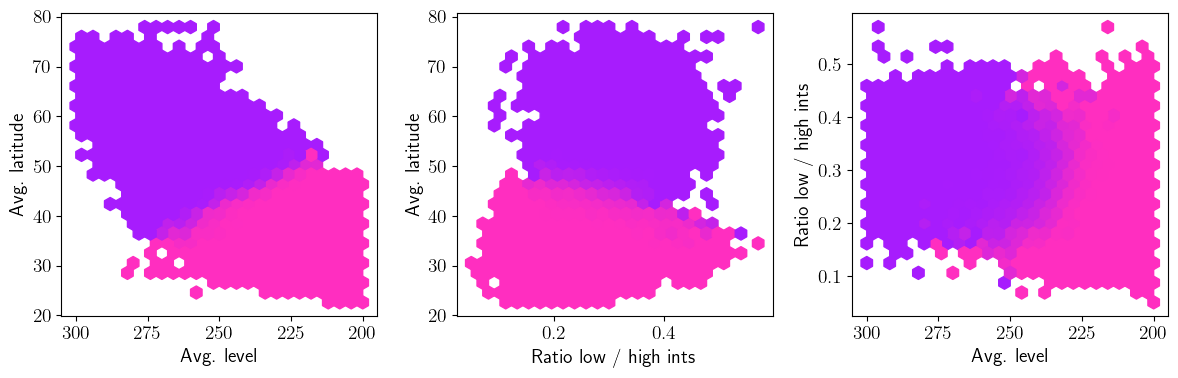

In [74]:
from sklearn.cluster import Birch
from jetstream_hugo.definitions import Timer

def to_zero_one(X):
    Xmin = X.min(axis=0)
    Xmax = X.max(axis=0)
    
    return (X - Xmin[None, :]) / (Xmax - Xmin)[None, :], Xmin, Xmax


def revert_zero_one(X, Xmin, Xmax):
    return Xmin[None, :] + (Xmax - Xmin)[None, :] * X

fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
season = "JJA"
feature_names = ["mean_lat", "mean_lev", "int_ratio"]
X, _ = extract_features(props_as_ds, feature_names, season)
X, Xmin, Xmax = to_zero_one(X)
with Timer():
    labels = Birch(threshold=0.2, n_clusters=2).fit(X).labels_
X = revert_zero_one(X, Xmin, Xmax)
for feature_ind, ax in zip(((1, 0), (2, 0), (1, 2)), axs):
    cmap = PINKPURPLE
    im = ax.hexbin(*X[:, feature_ind].T, gridsize=25, cmap=cmap, C=labels)
    try:
        ax.set_xlabel(PRETTIER_VARNAME[feature_names[feature_ind[0]]])
        ax.set_ylabel(PRETTIER_VARNAME[feature_names[feature_ind[1]]])
    except KeyError:
        ax.set_xlabel(feature_names[feature_ind[0]])
        ax.set_ylabel(feature_names[feature_ind[1]])
    if feature_names[feature_ind[0]] == "mean_lev":
        ax.invert_xaxis()
    if feature_names[feature_ind[1]] == "mean_lev":
        ax.invert_yaxis()